In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [18]:
volume = Volume(get_layers())

In [19]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e9), eff_opt=partial(torch.optim.SGD, lr=2e5),
                        loss_func=DetectorLoss(0))

In [20]:
from tomopt.optimisation import MetricLogger

In [21]:
ml = MetricLogger(show_plots=True)

In [22]:
trn_passives = PassiveYielder([arb_rad_length])

In [23]:
from tomopt.optimisation.callbacks.callback import Callback

In [24]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

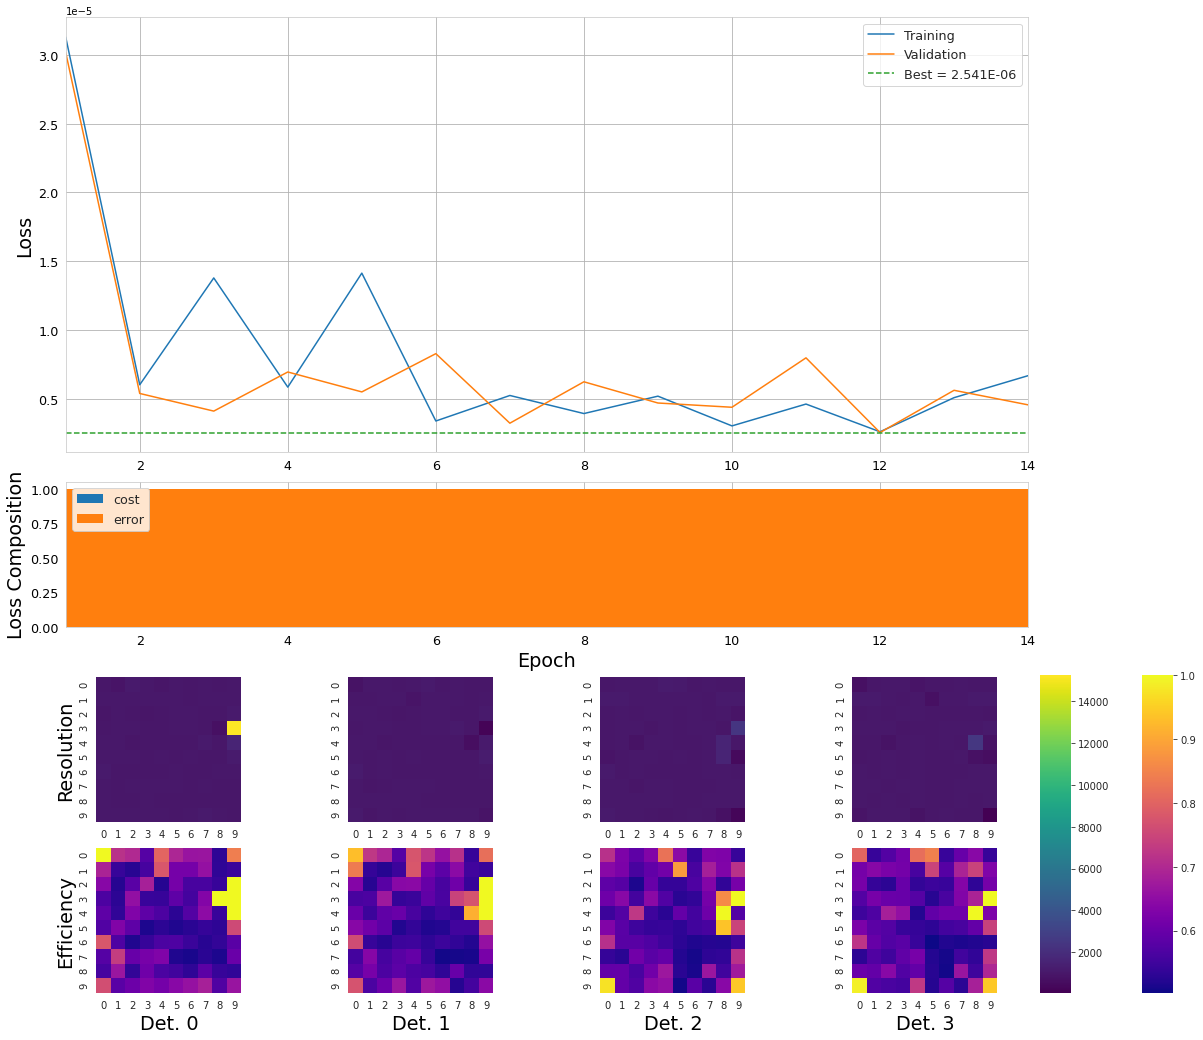

/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:203: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


KeyboardInterrupt: 

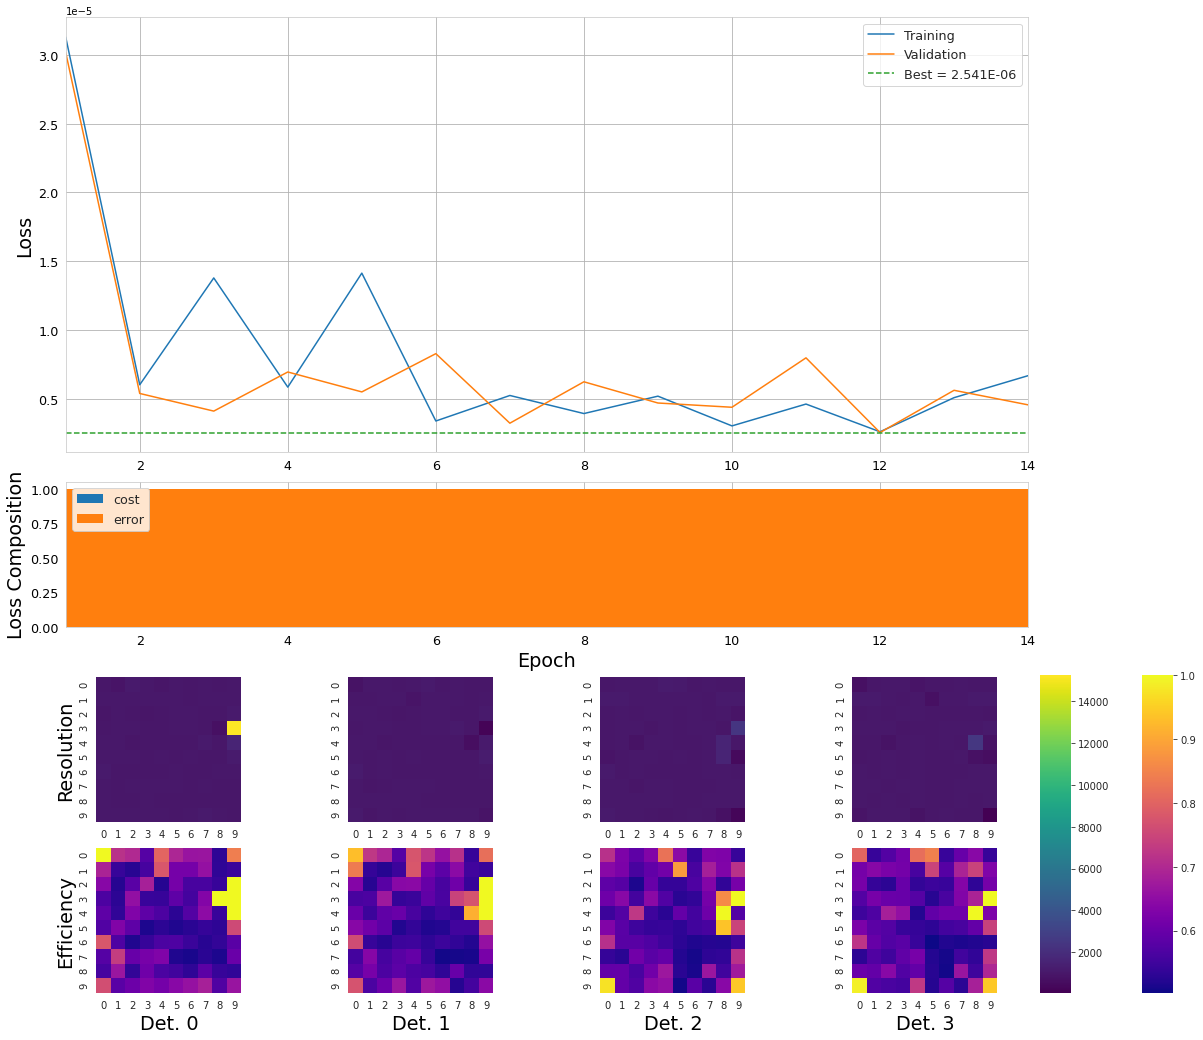

In [25]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ParamCap(),ml])

In [17]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)

1 Parameter containing:
tensor([[1003.5459, 1000.0000,  999.4371, 1000.0000, 1000.0000, 1001.8298,
         1000.0000,  994.1158,  995.3099,  994.1747],
        [1000.0000, 1000.0000,  999.9875, 1000.0000, 1000.0000,  941.9092,
         1000.0000, 1000.0000,  995.0880, 1006.1374],
        [ 994.1151, 1000.0000,  998.2100, 1000.0000,  992.5634, 1000.0000,
         1000.0000, 1000.0000,  999.0272,  998.4176],
        [ 938.8387,  995.7922,  996.9592, 1000.0000, 1000.0000, 1000.0000,
         1000.0000,  992.4672, 1000.0000,  994.1151],
        [ 993.6032,  992.5338,  996.9136, 1000.0000, 1000.0000, 1000.0000,
          996.6635, 1000.0000, 1000.0000, 1000.0000],
        [ 996.9725, 1000.0000, 1000.0000, 1000.0000, 1000.0000, 1000.0000,
         1000.0000,  994.7996,  995.1255, 1000.0000],
        [1000.0000, 1000.0000,  994.5992, 1000.0000,  985.4108, 1000.0000,
          995.9897,  995.5596, 1000.0000, 1000.0000],
        [ 994.5609, 1000.0000, 1000.0000, 1000.0000, 1000.0000,  996.4529